In [1]:
import os
import pandas as pd
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error
import numpy as np
from scipy.constants import c, h, k
from scipy.optimize import curve_fit,fsolve
import matplotlib.pyplot as plt
import tifffile as tif
import math
import plotly.graph_objects as go

In [2]:
## fix parameter

wl = np.array([0.548, 0.586, 0.628, 0.667, 0.704, 0.743, 0.786, 0.826])*10**(-6)
sens_factor = np.array([1754.7780081330168, 4614.964564504549, 9544.836689465254, 18681.526160164747, 28448.45940189293, 42794.15859091206, 61722.9332334226, 89214.96448715679])
sens_factor_b = [-625203.4109383911, -1255959.3399823632, -2280428.045299191, -2896486.193421305, -3511055.365513118, -2647879.5561356354, -496042.6119804597, 6119684.353094454]
# sens_factor_b = [0,0,0,0,0,0,0,0]
param1 = h * 2 * c ** 2
param2 = h * c / k 
emi = 1

In [3]:
homefolder = os.path.dirname(os.path.dirname(os.getcwd()))

In [13]:
## program parameter

experiment_folder = "10_MusTAM_EXP\Try_with_offaxisFactor/V0_bb_700"
et = 3.5

In [5]:
def getfile(homefolder, experiment_name):
    RAWdata_folder = homefolder + "/" + experiment_name
    os.chdir(RAWdata_folder)
    file_list = list(filter(lambda x: x[-5:] == ".tiff", os.listdir(RAWdata_folder)))
    file_list.sort()
    return file_list

In [6]:
## get data in form (series,x,y,channel)
def get_data(file_list):
    data = []
    for img_series in range(round(len(file_list) / 9)):
        data_betw = []
        for idx_chl in range(8):
            cI = tif.imread(file_list[img_series * 9 + idx_chl])
            data_betw.append(cI)
        data.append(data_betw)
    data = np.transpose(np.asarray(data),(0,2,3,1))
    return np.asarray(data)

In [7]:
## theory function & fit func
def GT(temp,wavelength):
    result_value = param1/(wavelength**5)/(np.exp(param2/(wavelength*temp))-1)
    return result_value
def fit_F(wl,a,b,t):
    return (a-b*(wl*10**6-0.548)/0.278)*GT(t,wl)

In [14]:
## get data
file_list = getfile(homefolder,experiment_folder)
data = get_data(file_list)
# data = data[:,25:70,10:50,:]
data = data[:,:,:,:]
ori_data = data
print(np.shape(data))
noise = data[0,0,0]

fig_idx = 0
target_img = data[fig_idx,:,:,7]
print(np.shape(target_img))
noise = data[fig_idx,0,0,:]
# threshold = 0.1*(target_img.max()-noise[7])
threshold = 70
filter_matr=(target_img>threshold)
filt_mat = target_img*filter_matr
fig_data = (data[fig_idx,:,:,:]-noise)*sens_factor/et+sens_factor_b

(1, 160, 170, 8)
(160, 170)


#Test


[1.00000000e+00 2.15487254e-13 9.17860909e+02]


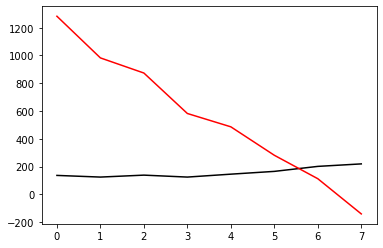

In [17]:
id_y = 40
id_x = 35
e_grey = 0.2
inten_array = fig_data[id_y,id_x]
popt,cov = curve_fit(fit_F,wl,e_grey *inten_array,bounds=((0.01,0,500),(1,1,3000)),maxfev=100000000)
y = fit_F(wl,popt[0],popt[1],popt[2])
plt.plot(ori_data[0,id_y,id_x,:],color="k")
plt.plot(noise+et/sens_factor*(y-sens_factor_b),color = "r")
print(popt)

[1.00000000e+00 2.15487254e-13 9.17860909e+02]


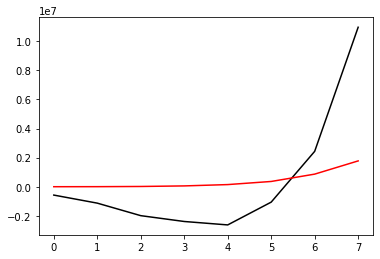

In [18]:
plt.plot(inten_array,color="k")
plt.plot(y,color = "r")
print(popt)

In [14]:

mat_array = []
for i in range(len(filt_mat[0])):
    for j in range(len(filt_mat)):
        if filt_mat[j,i]>0:
            mat_array.append([j,i])
mat_array = np.asarray(mat_array)
temp_mat = []
k_mat = []
b_mat = []
r2_map = []
for idx_arr in range(len(mat_array)):
    inten_array = []
    for idx_wl in range(8):
        inten_array.append(fig_data[mat_array[idx_arr,0],mat_array[idx_arr,1],idx_wl])
    popt,cov = curve_fit(fit_F,wl,inten_array,bounds=((0.01,0,500),(1,1,3000)),maxfev=100000000)
    y = fit_F(wl,popt[0],popt[1],popt[2])
    r2 = r2_score(y,inten_array)
    r2_map.append(r2)
    temp = popt[2]
    k_value = popt[0]
    k_mat.append(k_value)
    b_value = popt[1]
    b_mat.append(b_value)
    temp_mat.append(temp)
k_mat = np.asarray(k_mat)
b_mat = np.asarray(b_mat)
temp_mat = np.asarray(temp_mat)
print(np.mean(r2_map))

(160, 170)
-0.029064774096867585


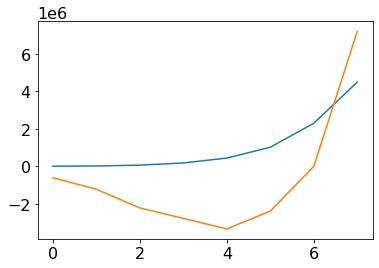

In [18]:
plt.plot(y)
plt.plot(inten_array)

In [16]:
plot_data = np.zeros(np.shape(data[fig_idx,:,:,7]))+1
k_map = np.zeros(np.shape(data[fig_idx,:,:,7]))+0.0001
b_map = np.zeros(np.shape(data[fig_idx,:,:,7]))+0.0001
plot_r2 = k_map
for i in range(len(plot_data)):
    for j in range(len(plot_data[1])):
        for k in range(len(mat_array)):
            if(mat_array[k,0]==i and mat_array[k,1]==j):
                plot_data[i,j]=temp_mat[k]
                k_map[i,j]=k_mat[k]
                b_map[i,j]=b_mat[k]
                plot_r2[i,j] = r2_map[k]


In [11]:
save_dir = "H:/1_Forschung/11_MusTAM_Analyse\HE_Result\linear_700bb"
df1 = pd.DataFrame(plot_data)
df2 = pd.DataFrame(k_map)
df3 = pd.DataFrame(b_map)
with pd.ExcelWriter(save_dir+"/700bb.xlsx") as writer:
    df1.to_excel(writer,sheet_name="T",index=False)
    df2.to_excel(writer,sheet_name="a",index=False)
    df3.to_excel(writer,sheet_name="b",index=False)

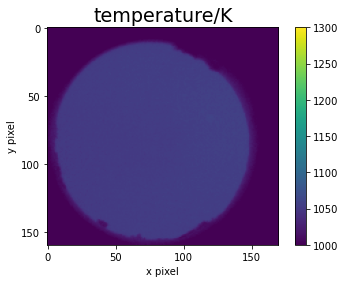

In [12]:
plt.clf()
im = plt.imshow(plot_data)
plt.colorbar(im, orientation='vertical')
plt.clim(1000, 1300)
plt.xlabel("x pixel")
plt.ylabel("y pixel")
plt.rcParams.update({'font.size': 16})
plt.title("temperature/K")
plt.savefig(save_dir+"/T.png")

In [13]:
print(n/((i+1)*(j+1))*100)
print(n)
print(i)

NameError: name 'n' is not defined

In [ ]:
plt.clf()
print(plot_data.max())
im = plt.imshow(data[0,:,:,7])
plt.colorbar(im, orientation='vertical')
plt.clim(0, 1023) 
plt.xlabel("x pixel")
plt.ylabel("y pixel")
plt.rcParams.update({'font.size': 16})
plt.title("temperature/K")

In [ ]:
plt.clf()
print(plot_data.max())
im = plt.imshow(k_map-b_map/2)
plt.colorbar(im, orientation='vertical')
plt.clim(0.8, 1) 
plt.xlabel("x pixel")
plt.ylabel("y pixel")
plt.rcParams.update({'font.size': 16})
plt.title("temperature/K")

In [ ]:

plot_y = np.linspace(0,len(target_img),len(target_img))
plot_x = np.linspace(0,len(target_img[1]),len(target_img[1]))
px,py = np.meshgrid(plot_x, plot_y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(px,py,plot_data)

In [ ]:
fig = go.Figure(data=[go.Surface(z=plot_data)])

camera = dict(
    up=dict(x=1, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=0.2, y=0.3, z=1)
)

fig.update_layout(scene_camera=camera)
fig.show()

In [ ]:
fig = go.Figure(data=[go.Surface(z=k_map)])
fig.show()

In [ ]:
fig = go.Figure(data=[go.Surface(z=b_map)])
fig.show()

In [ ]:
reconst = []
for i in range(len(plot_data)):
    reconst_ar = []
    for j in range(len(plot_data[1])):
        rec = fit_F(wl[7],k_map[i,j],b_map[i,j],plot_data[i,j])
        if rec > 1023:
            rec = 950
        reconst_ar.append(rec)
    reconst.append(reconst_ar)
reconst = np.asarray(reconst)

In [ ]:
recstr = (reconst+noise[7])/sens_factor[7]
rec_im = plt.imshow(recstr)
plt.colorbar(rec_im, orientation='vertical')
plt.clim(0, 323) 

In [ ]:
im=plt.imshow(data[fig_idx,:,:,7])
plt.colorbar(im, orientation='vertical')
plt.clim([0,323])

In [ ]:
fig = go.Figure(data=[go.Surface(z=recstr,cmin=0, cmax=1023)])
camera = dict(
    up=dict(x=1, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=0.2, y=0.3, z=1)
)

fig.update_layout(scene_camera=camera)
fig.show()

In [ ]:
fig = go.Figure(data=[go.Surface(z=data[fig_idx,:,:,7],cmin=0, cmax=1023)])
camera = dict(
    up=dict(x=1, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=0.2, y=0.3, z=1)
)

fig.update_layout(scene_camera=camera)
fig.show()

In [ ]:

plot_y = np.linspace(0,len(target_img),len(target_img))
plot_x = np.linspace(0,len(target_img[1]),len(target_img[1]))
px,py = np.meshgrid(plot_x, plot_y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(px,py,k_map)

In [ ]:
im = plt.imshow(plot_r2)
plt.colorbar(im, orientation='vertical')
plt.xlabel("x pixel")
plt.clim(0.6, 1) 
plt.rcParams.update({'font.size': 16})
plt.ylabel("y pixel")
plt.title("R2-score")

In [ ]:
im = plt.imshow(k_map)
plt.colorbar(im, orientation='vertical')
plt.xlabel("x pixel")
plt.rcParams.update({'font.size': 16})
plt.clim(0, 1) 
plt.ylabel("y pixel")
plt.title("k-factor")

In [ ]:
plt.clf()

In [ ]:
print(homefolder)
for i in range(len(plot_r2)):
    for j in range(len(plot_r2[0])):
        if plot_r2[i,j]>0 and plot_r2[i,j]<0.92:
            plt.rcParams['font.size'] = 15
            fst_try = (data[0,i,j]-noise)*sens_factor
            plt.plot(wl*10**6,fst_try,"--")
            plt.xlabel("corrected value")
            plt.ylabel("wavelength/µm")
            plt.title("x"+str(i)+"_y"+str(j)+"_"+str(plot_r2[i,j])[0:5])
            plt.grid()
            plt.savefig(homefolder+"\Result_calibration\initial_situation\off_problem_point/"+str(j)+"_"+str(i)+"_"+str(plot_r2[i,j])[0:5]+".png")
            plt.clf()